# Other Movies Like ... | Maybe You Like ...

Using KNN to find similar users and similar movies

## Setup And Exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Set default seed
np.random.seed(2802)

In [2]:
movies = pd.read_csv('datasets/movielens_100k/movies.csv')

movies.columns = ['movie_id', 'title', 'genres']
movies = movies.set_index('movie_id')

movies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('datasets/movielens_100k/ratings.csv')

ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = ratings.set_index('user_id')

ratings.head()

,movie_id,rating,timestamp
user_id,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931


In [4]:
ratings['rating'].isna().sum()

0

In [5]:
ratings['rating'].to_frame().describe().round(3)

,rating
count,100836.000
mean,3.502
std,1.043
min,0.500
25%,3.000
50%,3.500
75%,4.000
max,5.000


In [6]:
movies_count = pd.DataFrame(ratings.groupby('movie_id').size(),
                             columns=['count'])

movies_count = movies_count.sort_values('count', ascending=False)
movies_count = movies_count.reset_index(drop=True)

movies_count.head()

,count
0,329
1,317
2,307
3,279
4,278


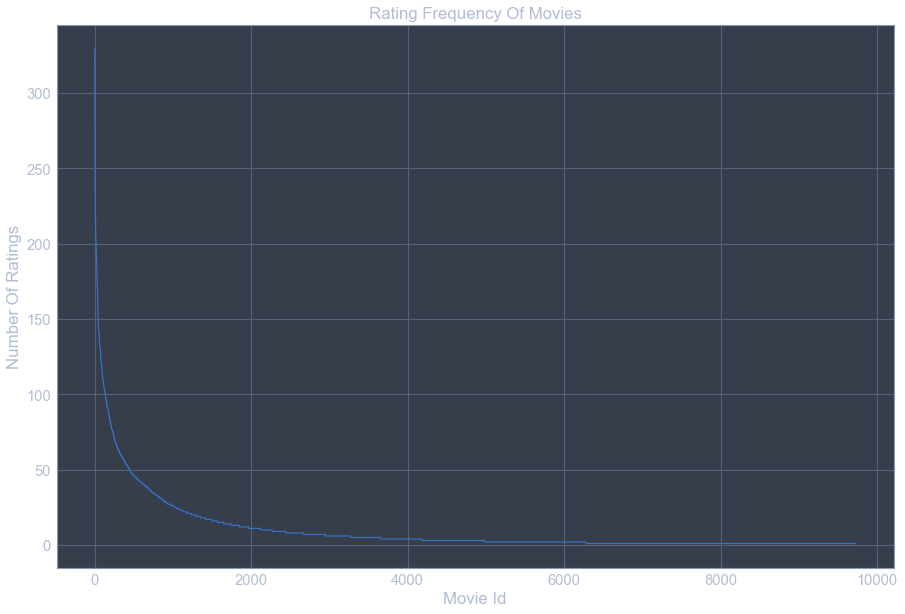

In [7]:
plt.figure(figsize=(15, 10))

ax = sns.lineplot(x=movies_count.index, y=movies_count['count'])

ax.set_title('Rating Frequency Of Movies')
ax.set_xlabel('Movie Id')
ax.set_ylabel('Number Of Ratings')

ax

## Filtering Data

In [8]:
min_ratings = 50

popular_movies_ids = list(set(movies_count[movies_count['count'] >= min_ratings].index))
popular_movies = ratings[ratings['movie_id'].isin(popular_movies_ids)]
popular_movies = popular_movies.reset_index()
popular_movies = popular_movies.set_index('movie_id')

popular_movies.head()

,user_id,rating,timestamp
movie_id,,,
1,1,4.0,964982703
3,1,4.0,964981247
6,1,4.0,964982224
47,1,5.0,964983815
50,1,5.0,964982931


In [9]:
users_count = pd.DataFrame(popular_movies.groupby('user_id').size(), columns=['count'])

users_count = users_count.sort_values('count', ascending=False)
users_count = users_count.reset_index(drop=True)

users_count.head()

,count
0,199
1,198
2,187
3,114
4,111


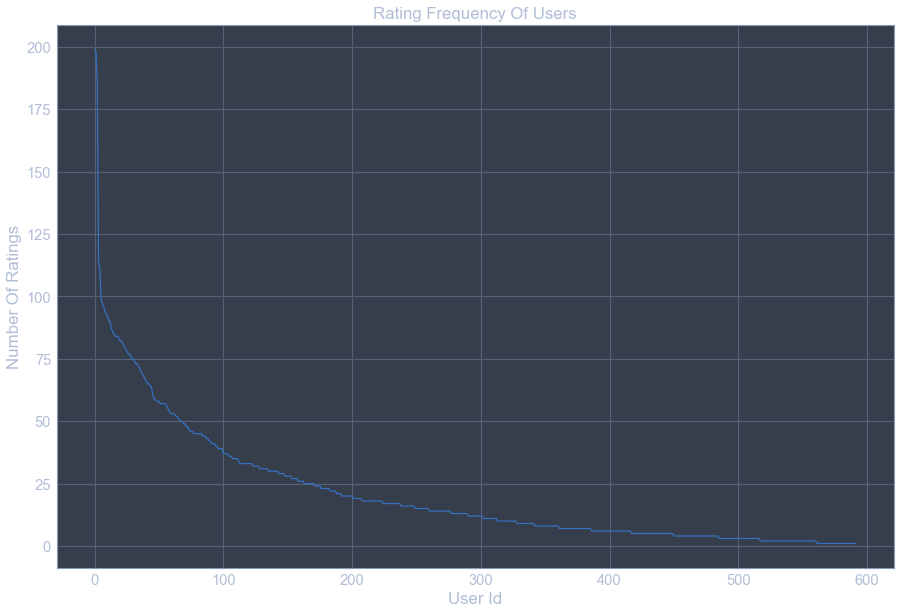

In [10]:
plt.figure(figsize=(15, 10))

ax = sns.lineplot(x=users_count.index, y=users_count['count'])

ax.set_title('Rating Frequency Of Users')
ax.set_xlabel('User Id')
ax.set_ylabel('Number Of Ratings')

ax

In [11]:
min_ratings = 50

active_users_ids = list(set(users_count[users_count['count'] >= min_ratings].index))
active_users = ratings[ratings.index.isin(active_users_ids)]

active_users.head()

,movie_id,rating,timestamp
user_id,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931


## Pre-Processing Data

In [12]:
active_users = active_users.reset_index()

movie_user = active_users.pivot(index='movie_id', columns='user_id', values='rating')
movie_user = movie_user.fillna(0)

movie_user.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,59,60,61,62,63,64,65,66,67,68
movie_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,2.5
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.5
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0


In [13]:
from scipy.sparse import csr_matrix

movie_user_matrix = csr_matrix(movie_user.values)
movie_user_matrix

<3496x68 sparse matrix of type '<class 'numpy.float64'>'
	with 11620 stored elements in Compressed Sparse Row format>

In [14]:
user_movie_matrix = csr_matrix(movie_user.transpose().values)
user_movie_matrix

<68x3496 sparse matrix of type '<class 'numpy.float64'>'
	with 11620 stored elements in Compressed Sparse Row format>

## Model Selection

In [15]:
from sklearn.neighbors import NearestNeighbors

model_movie_user = NearestNeighbors(n_neighbors=20,
                                    metric='cosine',
                                    algorithm='brute',
                                    leaf_size=100)

model_movie_user.fit(movie_user_matrix)
model_movie_user.kneighbors()

(array([[0.31425772, 0.32045027, 0.32290949, ..., 0.42754156, 0.42903987,
         0.43306666],
        [0.30873317, 0.36593929, 0.38042521, ..., 0.46095983, 0.4617234 ,
         0.46548105],
        [0.25191668, 0.25800446, 0.26727701, ..., 0.37976442, 0.38083842,
         0.38545839],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]), array([[ 379,  248,  667, ...,   39,   72,  570],
        [2809, 2085,  537, ...,  377, 2991,   28],
        [ 423,  345,    6, ...,  582,   81,  149],
        ...,
        [3297, 3036, 3240, ..., 2900, 2118, 3294],
        [1980, 2860, 1087, ..., 1963, 3085, 1877],
        [1980, 2860, 1087, ..., 1963, 3085, 1877]], dtype=int64))

In [16]:
model_user_movie = NearestNeighbors(n_neighbors=20,
                                    metric='cosine',
                                    algorithm='brute',
                                    leaf_size=100)

model_user_movie.fit(user_movie_matrix)
model_user_movie.kneighbors()

(array([[0.65496572, 0.67021777, 0.67207831, ..., 0.83903068, 0.8393112 ,
         0.84125551],
        [0.77399165, 0.77814687, 0.81021986, ..., 0.90627248, 0.90912024,
         0.91050245],
        [0.94027974, 0.95570333, 0.95796052, ..., 0.99124405, 0.99238897,
         0.99284365],
        ...,
        [0.65113135, 0.68599555, 0.69779068, ..., 0.8004043 , 0.80248207,
         0.80678495],
        [0.67187523, 0.69889631, 0.74999753, ..., 0.8385718 , 0.84082979,
         0.84219864],
        [0.56766139, 0.60630601, 0.61260172, ..., 0.76209851, 0.76472199,
         0.76825956]]), array([[56, 38, 44, ..., 19, 14,  6],
        [24, 64, 61, ..., 15, 20, 59],
        [ 0, 50, 54, ..., 19, 58, 32],
        ...,
        [63, 44, 56, ..., 14, 50, 40],
        [14, 16, 62, ..., 63, 60, 27],
        [63, 17, 44, ..., 50, 19, 16]], dtype=int64))

# Recommending Movies

In [17]:
def to_movie_title(movie_id):
    try:
        return (movie_id, movies.loc[movie_id]['title'])
    except:
        return None
        
def to_movie_info(movie):
    movie_title = to_movie_title(movie[0])
    if not movie_title:
        return None
    
    return (movie_title[1], round(movie[1], 4))

## By Similarity Of Movies

In [18]:
def recommend_by_similar_movies(movie_id, n_recommendations=10):
    title = movies.loc[movie_id]['title']
    print(f'Beacause you watched: {title}')
    
    distances, indexes = model_movie_user.kneighbors(movie_user_matrix[movie_id],
                                                     n_neighbors=n_recommendations + 1)

    distances = distances.squeeze().tolist()
    indexes = indexes.squeeze().tolist()
        
    found_movies = zip(indexes, distances)
    found_movies = filter(lambda movie: movie[0] != movie_id, found_movies)
    found_movies = map(to_movie_info, found_movies)
    found_movies = filter(lambda movie: movie is not None, found_movies)
    found_movies = sorted(found_movies, key=lambda movie: movie[1])
    
    return found_movies

In [19]:
# 1 => Toy Story
recommendations = recommend_by_similar_movies(1)
recommendations

Beacause you watched: Toy Story (1995)


[('101 Dalmatians (One Hundred and One Dalmatians) (1961)', 0.3659),
 ('Sirens (1994)', 0.3804),
 ('Back to the Future Part II (1989)', 0.3876),
 ('Dirty Dancing (1987)', 0.4154),
 ('D2: The Mighty Ducks (1994)', 0.4172),
 ('Cabin Boy (1994)', 0.4198),
 ('Death Wish 5: The Face of Death (1994)', 0.4255)]

## By Similarity Of Users

In [20]:
from functools import reduce

def to_user_distance(distances, user):
    if not distances:
        distances = {}
        
    distances[user[0]] = round(user[1], 4)
    return distances

def recommend_by_similar_users(user_id, n_users=3, n_recommendations=1, group_by_user=False):
    if user_id >= user_movie_matrix.shape[0]:
        return f'User: {user_id} not found'
    
    distances, indexes = model_user_movie.kneighbors(user_movie_matrix[user_id],
                                                     n_neighbors=n_users + 1)

    distances = distances.squeeze().tolist()
    indexes = indexes.squeeze().tolist()
        
    found_users = zip(indexes, distances)
    found_users = filter(lambda user: user[0] != user, found_users)
    found_users = sorted(found_users, key=lambda user: user[1])
    
    found_users_ids = map(lambda user: user[0], found_users)
    
    watched_movies = list(ratings[ratings.index == user_id]['movie_id'].values)

    recommendations_ids = set(watched_movies)
    recommendations = []
    for found_user_id in found_users_ids:
        if user_id == found_user_id:
            continue
        
        found_movies = popular_movies[popular_movies['user_id'] == found_user_id]
        found_movies = found_movies[~found_movies.index.isin(recommendations_ids)].nlargest(n_recommendations, 'rating')
                
        found_movies = set(found_movies.sort_values('rating').index)
        found_movies = list(found_movies)

        recommendations_ids.update(found_movies)

        size = len(found_movies)

        found_movies = map(to_movie_title, found_movies)
        found_movies = filter(lambda movie: movie is not None, found_movies)
    
        tmp_found_movies = []
        for movie in found_movies:
            movie_idx, title = movie
            
            rating = ratings.loc[found_user_id]
            rating = rating[rating['movie_id'] == movie_idx]['rating'].values[0]
            
            tmp_found_movies.append((title, found_user_id, rating))
        
        found_movies = tmp_found_movies
        if len(found_movies):
            if group_by_user:
                recommendations.append(found_movies)
                recommendations = sorted(recommendations, key=lambda user: user[0][2], reverse=True)
            else:
                recommendations.extend(found_movies)
                recommendations = sorted(recommendations, key=lambda user: user[2], reverse=True)
    
    return recommendations

In [21]:
recommendations = recommend_by_similar_users(1, n_users=10)
recommendations

[('Casino (1995)', 64, 5.0),
 ('Screamers (1995)', 51, 5.0),
 ('GoldenEye (1995)', 21, 5.0),
 ('Léon: The Professional (a.k.a. The Professional) (Léon) (1994)', 62, 5.0),
 ('Sense and Sensibility (1995)', 40, 5.0),
 ('Shawshank Redemption, The (1994)', 24, 4.5),
 ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 61, 4.5),
 ('Taxi Driver (1976)', 17, 4.0),
 ('Apollo 13 (1995)', 29, 4.0),
 ('City of Lost Children, The (Cité des enfants perdus, La) (1995)', 23, 4.0)]

## Checking Recommendations

In [22]:
user_id = 64

user_movie_ratings = ratings.loc[user_id].nlargest(10, 'rating')
user_movie_ratings = user_movie_ratings.reset_index()
user_movie_ratings = user_movie_ratings.set_index('movie_id')

user_movie_ratings = user_movie_ratings.join(movies)
user_movie_ratings = user_movie_ratings[['user_id', 'title', 'rating']]

user_movie_ratings

,user_id,title,rating
movie_id,,,
16,64,Casino (1995),5.0
266,64,Legends of the Fall (1994),5.0
318,64,"Shawshank Redemption, The (1994)",5.0
527,64,Schindler's List (1993),5.0
590,64,Dances with Wolves (1990),5.0
593,64,"Silence of the Lambs, The (1991)",5.0
778,64,Trainspotting (1996),5.0
858,64,"Godfather, The (1972)",5.0
1090,64,Platoon (1986),5.0


*Notes:*

This model has some limitations:

- **Popularity bias:** When only the most popular movies will be considered on the recommendation.
- **Could start:** When there aren't many movies watched, the recommendation tends not to be very accurate.

# Saving Model

In [23]:
import os
import pickle

def save_model(filepath, fitted_model):
    try:
        path, _ = os.path.split(filepath)
        if not os.path.exists(path):
            os.makedirs(path)
        
        with open(filepath, 'wb') as f:
            pickle.dump(fitted_model, f)
    except Exception as e:
        print(e)

        
def load_model(filepath):
    fitted_model = None
    try:
        with open(filepath, 'rb') as f:
            fitted_model = pickle.load(f)
            
        return fitted_model
    except Exception as e:
        print(e)

In [24]:
# Saving user based model
filename = 'knn_collaborative_user_movie.pkl'
filepath = f'models/{filename}'

save_model(filepath, model_user_movie)

# Saving movie based model
filename = 'knn_collaborative_movie_user.pkl'
filepath = f'models/{filename}'

save_model(filepath, model_movie_user)